In [3]:
import numpy as np
import os
import gzip
import struct
import random
import time
import signal

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import clear_output, display

from util import *
from node import *
from optim import *
from net import Net

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
text = ""
ddir = "data/books/witcher_rus/"
for fn in sorted(os.listdir(ddir)):
    if fn.endswith(".gz"):
        with gzip.open(ddir + fn, "rb") as f:
            text += f.read().decode("utf-8").replace("\r", "")
charset = sorted(set(text))
print(charset)
print("%s chars, %s unique" % (len(text), len(charset)))
chidx = {ch: i for i, ch in enumerate(charset)}

raw_data = [chidx[ch] for ch in text]
data = np.array(raw_data, dtype=np.uint8)
dvec = np.eye(len(charset), dtype=np.float64)

['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']
5088376 chars, 140 unique


In [46]:
batch_size = 100
seqlen = 100

blen = len(data)//batch_size
print("%s chars in sequence" % blen)
bseqdata = data[:blen*batch_size].reshape(batch_size, blen).transpose()
#print(''.join([charset[k] for k in bseqdata.transpose()[-1]]))

50883 chars in sequence


In [47]:
class RNN(Net):
    def __init__(self, sizes):
        self.sizes = sizes
        sx, sh, sy = sizes
        layers = [
            Affine(sx, sh), # W_xh
            Affine(sh, sh), # W_hh
            Affine(sh, sy), # W_hy
            Tanh()
        ]
        links = [
            ((-1, 0), 0), # x
            ((-1, 1), 1), # h_in
            (0, 3),
            (1, 3),
            (3, 2),
            (3, (-1, 1)), # h_out
            (2, (-1, 0)), # y
        ]
        super().__init__(layers, links)
    
    def newstate(self, count):
        return np.zeros((count, self.sizes[1]), dtype=np.float64)

In [75]:
hidden_size = 100
#cell_size = 30
net = RNN((len(charset), hidden_size, len(charset)))

In [76]:
epoch = 0
pos = 0
smooth_loss = None
history = [[], []]
h = net.newstate(batch_size)

In [77]:
learn_rate = 1e-1
reg_rate = 0
grad_clip = 5
optim = Adagrad(
    learn_rate=learn_rate, 
    adagrad=net.newgrad(), 
    reg_rate=reg_rate
)

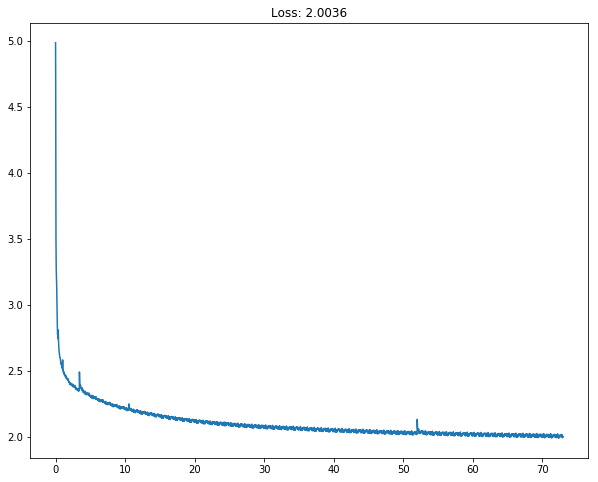

done


In [90]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

while not done:
    loss = 0.0
    memory = []
    for x, ir in zip(dvec[bseqdata[pos:pos+seqlen]], bseqdata[pos+1:pos+seqlen+1]):
        (y, h), m = net.feed_mem((x, h))
        smy = softmax(y)
        memory.append((m, smy, ir))
        loss += ce_loss(smy, ir)
    loss /= len(memory)
    
    grad = net.newgrad()
    dh = net.newstate(batch_size)
    for m, smy, ir in reversed(memory):
        _, dh = net.backprop(grad, m, (ce_softmax_deriv(smy, ir), dh))
    
    optim.learn(net, grad, norm=len(memory), clip=grad_clip)
    
    if smooth_loss is None:
        smooth_loss = loss
    smooth_loss = 0.9*smooth_loss + 0.1*loss
        
    if (pos//seqlen) % 10 == 0:
        history[0].append(epoch + pos/bseqdata.shape[0])
        history[1].append(smooth_loss)
        clear_output(wait=True)
        plt.plot(history[0], history[1])
        plt.title("Loss: %.4f" % history[1][-1])
        plt.show()
    
    pos += seqlen
    if pos >= bseqdata.shape[0] - 1:
        pos = 0
        epoch += 1
        h = net.newstate(batch_size)

print("done")

In [89]:
_h = h[0]
smp = ""
c = bseqdata[pos][0]
x = dvec[c].reshape(1, -1)
smp += charset[c]
for i in range(1000):
    y, _h = net.feed((x, _h))
    smy = softmax(y)
    c = np.random.choice(np.arange(len(charset)), p=smy.reshape(-1))
    smp += charset[c]
    x = dvec[c].reshape(1, -1)
print(smp)

., об одкогоссинием этой это поверегде, здаркрости за спросно. Думают - по ддевледя руки. Салет с и столько выйнию жревнос ей дераст, не отнавать, воятье, свисилось дутом.

- Нетска, повидьких колюшь мнайся так биганельхе дать нье-нибромьма он нригсаю соромного госмеркла госкольшого обужто окрипак, всюди, ком ускоторы объеивы, когда хль схвотанием с лаву жра чер упат. Внетется все в Итрется себе. А слажили тать коллели редом саже что увапльзе тебо не успащался? Красце истью, знает.

- Дели продреннисыка, они Лютичелнулольного и верила прибласть то я парам, колови подим слузмари. Проил одиц, девут тепу. Вы в ое они летент сказал ликовать. Он поднадал сказала зомжеть а оше сина за знают.

Ведьмак. - Стаереных она сделает, повер пож просбелиство-раста постартищаюсь в отот-нес был. Стала станком король, от уданицапи, которые - припаясы закрыми он вивой стинулсей. Одно ничего другие к держжять ребязный ны завлечаться: рышет. Несхонтэ, потом, - стахо.

- Ну с лучкий ничь из-то сропоня, астит

In [ ]:
class LearningContext:
    def __init__(self, **params):
        self.params = params
        self.name = params["name"]
        
        inout_size = len(charset)
        if params.get("lstm", False):
            self.net = LSTM(inout_size, params["hidden_size"], params["cell_size"], inout_size)
            self.h, self.c = self._newmem()
        else:
            self.net = RNN(inout_size, params["hidden_size"], inout_size)
            self.h = self._newmem()
        
        self.loss = None
        self.loss_history = []
        
        self.adagrad = self.net.newgrad() if params.get("adagrad", False) else None
        
    def _newmem(self):
        return self.net.newstate(self.params["batch_size"])
        
    def learn(self, inseq, outseq):
        assert inseq.shape[0] == outseq.shape[0]
        seqlen = inseq.shape[0]
        
        loss = 0.0
        memory = []
        
        if params.get("clearmem", False):
            h = self.h
        else:
            h = self._newmem()
            
        for x, ir in zip(dvec[inseq], outseq):
            (y, h), m = net.feed_mem((x, h))
            smy = softmax(y)
            memory.append((m, smy, ir))
            loss += ce_loss(smy, ir)
        loss /= len(memory)
        
        self.h = h

        grad = net.newgrad()
        dh = net.newstate(self.params["batch_size"])
        for m, smy, ir in reversed(memory):
            _, dh = net.backprop(grad, m, (ce_softmax_deriv(smy, ir), dh))

        optim.learn(net, grad, norm=len(memory), clip=grad_clip)

        if self.loss is None:
            self.loss = loss
        else:
            self.loss = 0.99*self.loss + 0.01*loss

def sample(self, seed, textlen):
    h = self.h[0]
    text = ""
    c = seed
    x = dvec[c].reshape(1, -1)
    text += charset[c]
    for i in range(textlen):
        y, h = net.feed((x, h))
        smy = softmax(y)
        c = np.random.choice(np.arange(len(charset)), p=smy.reshape(-1))
        text += charset[c]
        x = dvec[c].reshape(1, -1)
    return text

In [ ]:
def cmprnn(net):
    n = 5

    W_xh, W_hh, W_hy = [np.copy(net.nodes[j].W) for j in range(3)]
    
    x = np.random.random(net.sizes[0])
    h = np.random.random(net.sizes[1])

    v = np.dot(x, W_xh) + np.dot(h, W_hh)
    a = np.tanh(v)
    y = np.dot(a, W_hy)

    m = [x, h, v, a, y]

    (_y, _a), _m = net.feed_mem((x.reshape(1, -1), h.reshape(1, -1)))
    print(y - _y.reshape(-1), a - _a.reshape(-1))

    _grad = net.newgrad()

    ey = np.random.random(net.sizes[2])
    eh = np.random.random(net.sizes[1])

    dW_xh, dW_hh, dW_hy = [np.zeros_like(W) for W in [W_xh, W_hh, W_hy]]
    x, h, v, a, y = m

    dW_hy += np.outer(a, ey)
    ea = np.dot(W_hy, ey) + eh
    ev = ea*tanh_deriv(v)
    dW_xh += np.outer(x, ev)
    dW_hh += np.outer(h, ev)
    eh_ = np.dot(W_hh, ev)

    _ex, _eh_ = net.backprop(_grad, _m, (ey.reshape(1, -1), eh.reshape(1, -1)))
    print(_eh_ - eh_)

    for dW, _dW in zip([dW_xh, dW_hh, dW_hy], [_grad.params[j].W for j in range(3)]):
        print(dW - _dW)

    learning_rate = 1e-1

    for W, dW in zip([W_xh, W_hh, W_hy], [dW_xh, dW_hh, dW_hy]):
        dW /= n
        np.clip(dW, -5, 5, out=dW)
        W -= learning_rate*dW

    _optim = SGD(learn_rate=learning_rate)
    _optim.learn(net, _grad, norm=n, clip=5)
    
    for W, _W in zip([W_xh, W_hh, W_hy], [net.nodes[j].W for j in range(3)]):
        print(W - _W)
    
cmprnn(net)

In [4]:
charset = sorted(set("".join(charset).lower()))
print(charset)
chidx = {ch: i for i, ch in enumerate(charset)}
chvec = {ch: np.array([chidx[ch] == i for i in range(len(charset))], dtype=np.float64) for ch in charset}
for ch in charset:
    if ch.islower():
        chidx[ch.upper()] = chidx[ch]
        chvec[ch.upper()] = chvec[ch]